# Project for Course 7: Historical Structures Classification
## By John Hamilton

## PART 1 - Build deep learning model for Image Classification

### Import the required libraries

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.applications.nasnet import NASNetLarge
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 512
img_height = 128
img_width = 128


### Make sure there are no invalid image files in the data that need to be deleted


In [2]:
from pathlib import Path
import imghdr

image_extensions = [".jpg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

def check_image_files(data_dir):
    for filepath in Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

data_dir = "./Stuctures_Dataset"
check_image_files(data_dir)
data_dir = "./Dataset_test_original_1478"
check_image_files(data_dir)


C:\Users\jbham\AppData\Local\Temp\ipykernel_17548\2293567428.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Check the integrity of the image files and report any bad files so we can delete them

In [3]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for filepath in Path(data_dir).rglob("*/*"):
    image = JPEG(filepath) 
    try:
        image.decode()   
    except:
        bads.append(filepath)

print(bads)

[]


### Take a look at some of the images

Class: Stuctures_Dataset\altar


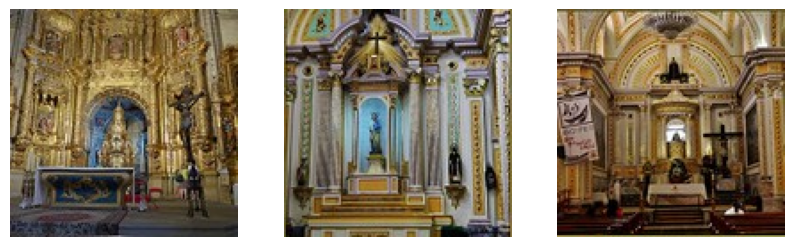

Class: Stuctures_Dataset\apse


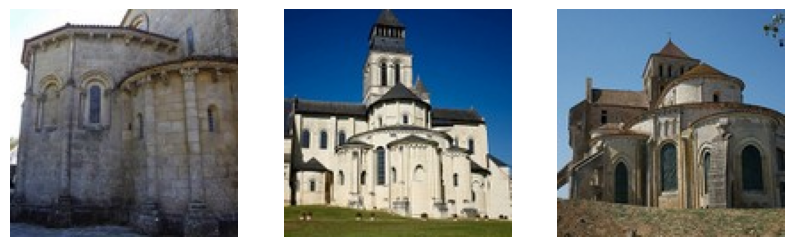

Class: Stuctures_Dataset\bell_tower


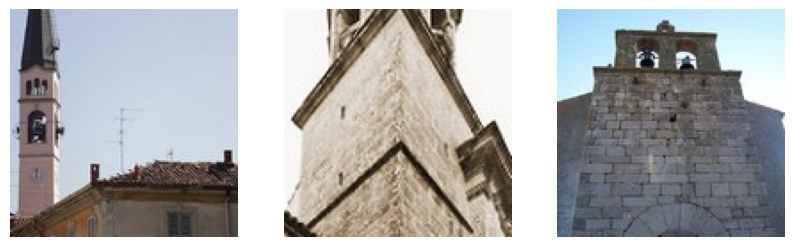

Class: Stuctures_Dataset\column


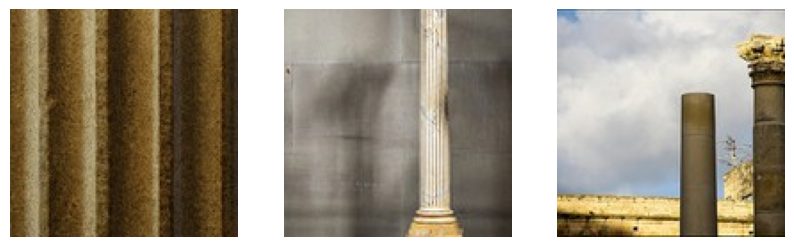

Class: Stuctures_Dataset\dome(inner)


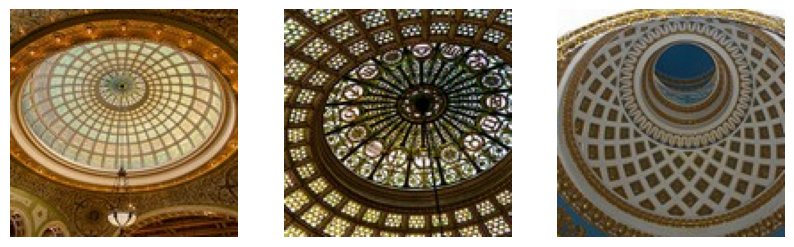

Class: Stuctures_Dataset\dome(outer)


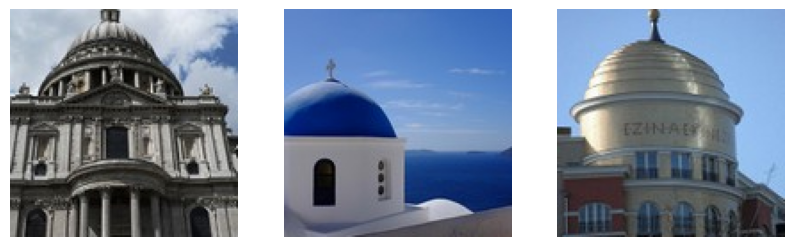

Class: Stuctures_Dataset\flying_buttress


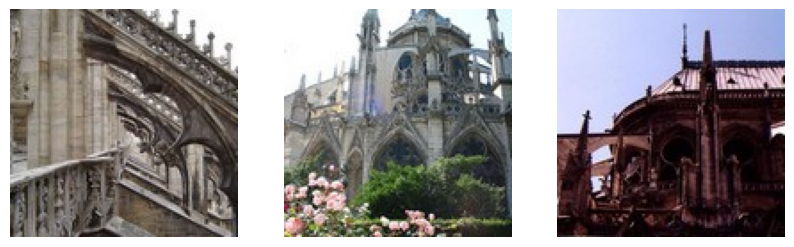

Class: Stuctures_Dataset\gargoyle


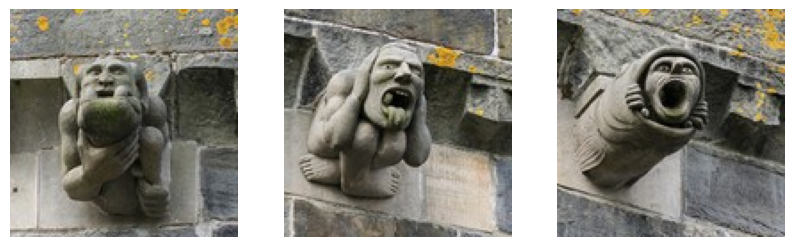

Class: Stuctures_Dataset\portal


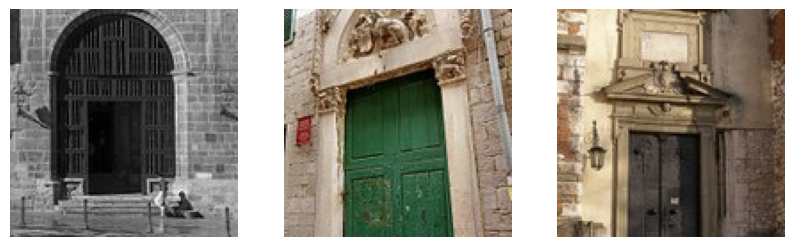

Class: Stuctures_Dataset\stained_glass


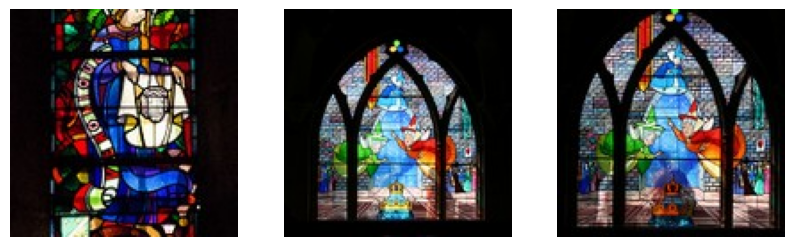

Class: Stuctures_Dataset\vault


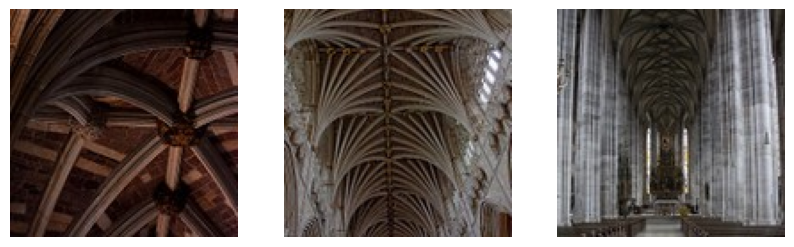

Class: Dataset_test_original_1478\altar


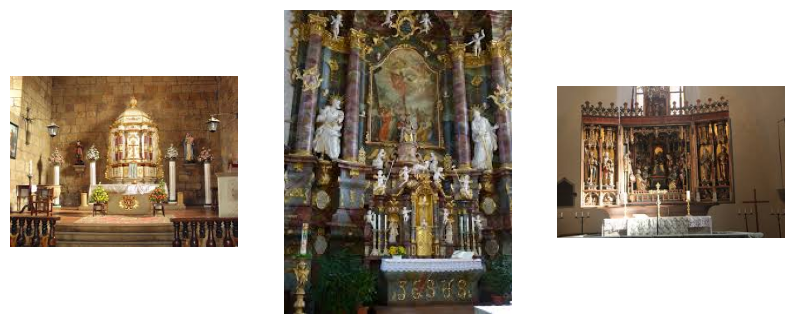

Class: Dataset_test_original_1478\apse


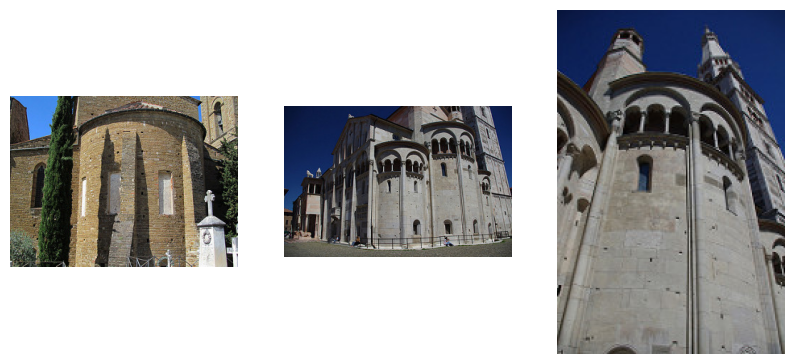

Class: Dataset_test_original_1478\bell_tower


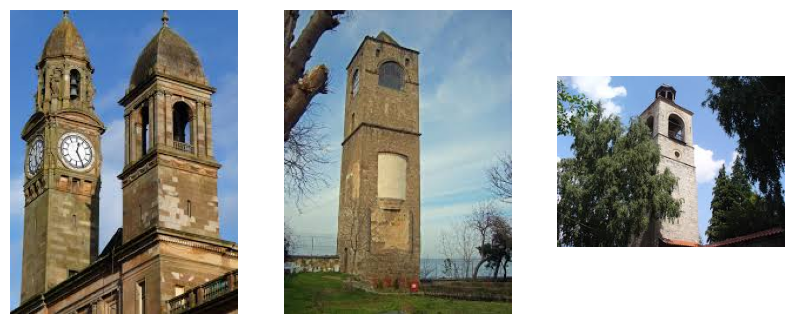

Class: Dataset_test_original_1478\column


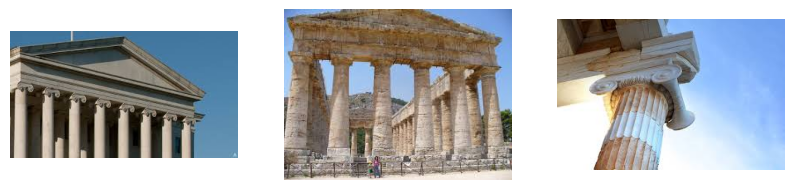

Class: Dataset_test_original_1478\dome(inner)


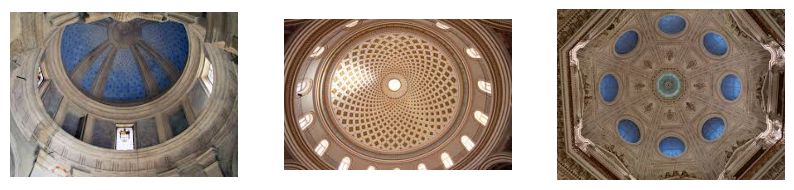

Class: Dataset_test_original_1478\dome(outer)


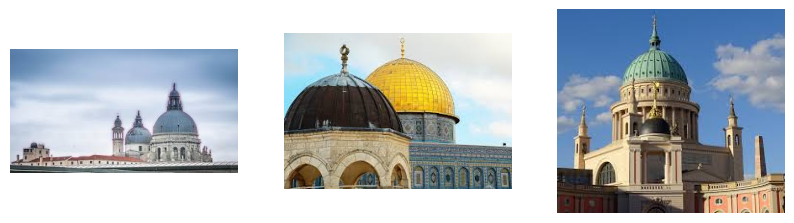

Class: Dataset_test_original_1478\flying_buttress


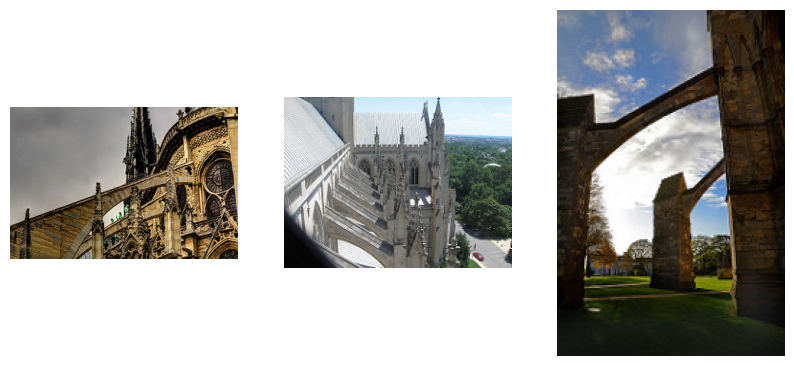

Class: Dataset_test_original_1478\gargoyle


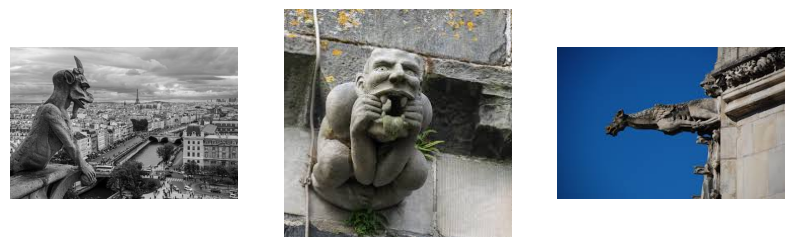

Class: Dataset_test_original_1478\portal


<Figure size 1000x1000 with 0 Axes>

Class: Dataset_test_original_1478\stained_glass


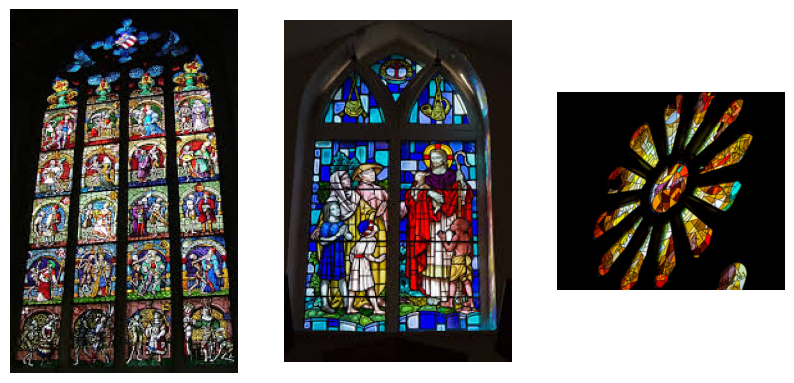

Class: Dataset_test_original_1478\vault


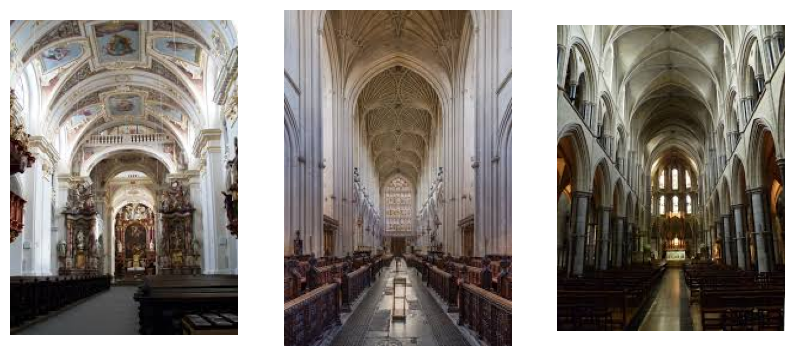

In [4]:
import os
import matplotlib.image as mpimg

def display_image_files(data_dir):
    for dir in Path(data_dir).iterdir():
        print (f'Class: {dir}')
        fig = plt.figure(figsize=(10, 10))         
        count = 0
        for filename in os.listdir(dir):
            count += 1
            if (count <= 3):
                image = mpimg.imread(f'{dir}\\{filename}')
                fig.add_subplot(1, 3, count)
                plt.imshow(image)
                plt.axis('off') 
        plt.show()

display_image_files('Stuctures_Dataset')      
display_image_files('Dataset_test_original_1478')      


### Load classified images from disk into Train and Test datasets

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Stuctures_dataset',
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

test_ds = tf.keras.utils.image_dataset_from_directory(
  'Dataset_test_original_1478',
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

class_names = train_ds.class_names
num_classes = len(class_names)

Found 9977 files belonging to 11 classes.
Found 1439 files belonging to 11 classes.


### Adjust datasets for use in the CNN:
1. Apply normalization to images (x)
2. Change labels to categorical (y)

In [6]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), keras.utils.to_categorical(y, num_classes=num_classes)))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), keras.utils.to_categorical(y, num_classes=num_classes)))


### Create the Convolutional Neural Network by specifying its layers

In [7]:
model = Sequential([
  NASNetLarge(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet'),
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.1),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the CNN

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','precision','recall'])

### Create Early Stopping callback to be passed into model.fit()

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


### Train the model on the training dataset and test using the test dataset (without augmentation)

In [10]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping] 
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 626s 27s/step - accuracy: 0.5992 - loss: 1.2894 - precision: 0.8813 - recall: 0.4594 - val_accuracy: 0.5337 - val_loss: 37.0114 - val_precision: 0.5341 - val_recall: 0.5337
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 557s 28s/step - accuracy: 0.9494 - loss: 0.2360 - precision: 0.9695 - recall: 0.9170 - val_accuracy: 0.6650 - val_loss: 22.2792 - val_precision: 0.6660 - val_recall: 0.6650
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 555s 28s/step - accuracy: 0.9756 - loss: 0.1024 - precision: 0.9833 - recall: 0.9684 - val_accuracy: 0.6074 - val_loss: 18.3247 - val_precision: 0.6075 - val_recall: 0.6067
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 563s 28s/step - accuracy: 0.9810 - loss: 0.0719 - precision: 0.9853 - recall: 0.9766 - val_accuracy: 0.4892 - val_loss: 64.3581 - val_precision: 0.4892 - val_recall: 0.4892
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 561s 28s/step - accuracy: 0.9868 - loss: 0.0652 - precision: 0.9896 - recall: 0.9822 - val_accuracy: 0.6449 - val_loss

### Plot Training vs Validation accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

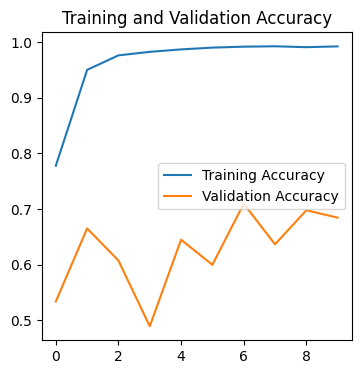

In [11]:
epochs = early_stopping.stopped_epoch+1

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='right')
plt.title('Training and Validation Accuracy')


### Apply augmentation and rescale the data

In [2]:
train_aug = ImageDataGenerator (rescale = 1./255,shear_range = 0.3,zoom_range = 0.7,horizontal_flip = True)
test_aug = ImageDataGenerator (rescale=1./255)

train_ds = train_aug.flow_from_directory(
  "Stuctures_Dataset", 
  seed=42,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True
)

test_ds = test_aug.flow_from_directory(
  "Dataset_test_original_1478",
  seed=42,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True
)

Found 9977 images belonging to 11 classes.
Found 1439 images belonging to 11 classes.


### Recreate the model and refit

In [10]:
augmented_model = Sequential([
  NASNetLarge(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet'),
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.1),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes, activation='softmax')
])

augmented_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','precision','recall'])

early_stopping2 = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

epochs=50
history2 = augmented_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping2]  
)

Epoch 1/50


c:\Users\jbham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 640s 28s/step - accuracy: 0.5768 - loss: 1.3723 - precision: 0.8657 - recall: 0.4276 - val_accuracy: 0.4892 - val_loss: 25.5842 - val_precision: 0.4892 - val_recall: 0.4892
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 586s 29s/step - accuracy: 0.8963 - loss: 0.3803 - precision: 0.9358 - recall: 0.8691 - val_accuracy: 0.4190 - val_loss: 40.8873 - val_precision: 0.4189 - val_recall: 0.4183
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 633s 32s/step - accuracy: 0.9312 - loss: 0.2549 - precision: 0.9560 - recall: 0.9070 - val_accuracy: 0.6553 - val_loss: 14.5492 - val_precision: 0.6564 - val_recall: 0.6546
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 586s 29s/step - accuracy: 0.9427 - loss: 0.2164 - precision: 0.9555 - recall: 0.9298 - val_accuracy: 0.5254 - val_loss: 37.4650 - val_precision: 0.5265 - val_recall: 0.5254
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 572s 28s/step - accuracy: 0.9538 - loss: 0.1685 - precision: 0.9644 - recall: 0.9393 - val_accuracy: 0.6650 - val_loss: 12.4769 -

### Plot Training vs Validation accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

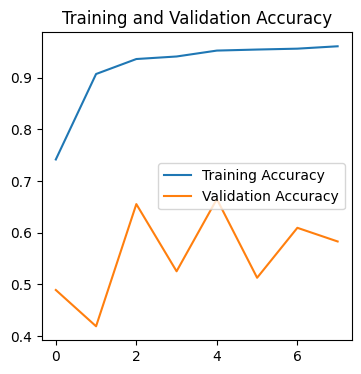

In [11]:
epochs = early_stopping2.stopped_epoch+1

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='right')
plt.title('Training and Validation Accuracy')


### Observations
1. On both unaugmented and augmented models, the accuracy improved overall but spent a lot of time moving up and down
2. Even though we added more images via augmentation, the augmented model did not do better than the unaugmented one

## PART 2 - Exploratory Data Analysis and Recommender Model

### First we load the users dataset and take a quick look at the head of the data

In [1]:
import numpy as np
import pandas as pd

df_users = pd.read_csv("user.csv")
df_users.head()


User_Id                   Location  Age
0        1      Semarang, Jawa Tengah   20
1        2         Bekasi, Jawa Barat   21
2        3        Cirebon, Jawa Barat   23
3        4         Bekasi, Jawa Barat   21
4        5  Lampung, Sumatera Selatan   20

### Check the info for the dataset

In [2]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


### Convert column to category and check for zeros

In [3]:
df_users['Location'] = pd.Categorical(df_users['Location'])

print('Zeros:\n', df_users[df_users==0].count(), sep='')

Zeros:
User_Id     0
Location    0
Age         0
dtype: int64


### Now load the ratings dataset and take a quick look at the head of the data

In [4]:
df_ratings = pd.read_csv("tourism_rating.csv")
df_ratings.head()

User_Id  Place_Id  Place_Ratings
0        1       179              3
1        1       344              2
2        1         5              5
3        1       373              3
4        1       101              4

### Check the info for the dataset

In [5]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


### Check for zeros

In [6]:
print('Zeros:\n', df_ratings[df_ratings==0].count(), sep='')

Zeros:
User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64


### Now load the locations dataset and look at the head

In [7]:
df_locations = pd.read_excel("tourism_with_id.xlsx")
df_locations.head()

Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   

    Price  Rating  Time_Minutes  \
0   20000     4.6          15.0   
1       0     4.6          90.0   
2  270000     4.6         360.0   
3   10000     4.5           NaN   
4   94000     4.5          60.0   

                                        Coordinate       Lat        Long  \
0          {'lat': -6.1753924, 'lng': 106.8271528} -6.175392  106.827153   
1  {'lat': -6.137644799999999, 'lng': 106.8171245} -6.137645  106.817125   
2  {'lat': -6.125312399999999, 'lng': 106.8335377} -6.125312  106.833538   
3  {'lat': -6.302445899999999, 'lng': 106.8951559} -6.302446  106.895156   
4             {'lat': -6.12419, 'lng': 106.839134} -6.124190  106.839134   

   Unnamed: 11  Unnamed: 12  
0          NaN            1  
1          NaN            2  
2          NaN            3  
3          NaN            4  
4          NaN            5

### Check the info for the dataset

In [8]:
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


### Clean up columns, replace NaN, and count zeros

In [9]:
df_locations['Category'] = pd.Categorical(df_locations['Category'])
df_locations['City'] = pd.Categorical(df_locations['City'])
df_locations.drop(['Coordinate', 'Unnamed: 11', 'Unnamed: 12'], axis=1, inplace=True)
df_locations.fillna({'Time_Minutes': 0}, inplace=True)

print('Zeros:\n', df_locations[df_locations==0].count(), sep='')

Zeros:
Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price           137
Rating            0
Time_Minutes    232
Lat               0
Long              0
dtype: int64


Zeros are OK for Price and Time_Minutes

### Check location dataset column stats

In [10]:
df_locations.describe().T

count          mean           std         min         25%  \
Place_Id      437.0    219.000000    126.295289    1.000000  110.000000   
Price         437.0  24652.173913  66446.374709    0.000000    0.000000   
Rating        437.0      4.442792      0.208587    3.400000    4.300000   
Time_Minutes  437.0     38.752860     54.876745    0.000000    0.000000   
Lat           437.0     -7.095438      0.727241   -8.197894   -7.749590   
Long          437.0    109.160142      1.962848  103.931398  107.578369   

                      50%           75%            max  
Place_Id       219.000000    328.000000     437.000000  
Price         5000.000000  20000.000000  900000.000000  
Rating           4.500000      4.600000       5.000000  
Time_Minutes     0.000000     60.000000     360.000000  
Lat             -7.020524     -6.829411       1.078880  
Long           110.237468    110.431869     112.821662

Everything looks good. Price and Time_Minutes have zeros in the lower quartiles but that is ok I think.

### Analyze the age distribution of the users

<Axes: xlabel='Age', ylabel='Count'>

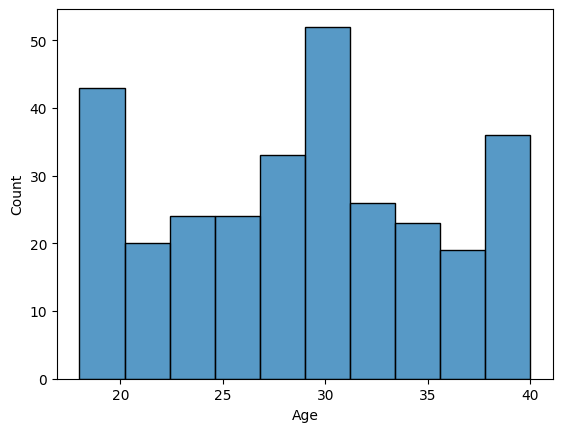

In [11]:
import seaborn as sns

sns.histplot(df_users['Age'])

Observations:
1. Most of the users are between 25 and 35
2. More users are 30 than any other age
3. However, there are surges at the youngest and oldest ages

### Where are most of these users coming from?

In [12]:
df_users.Location.value_counts()

Location
Bekasi, Jawa Barat              39
Semarang, Jawa Tengah           22
Lampung, Sumatera Selatan       20
Yogyakarta, DIY                 20
Bogor, Jawa Barat               17
Cirebon, Jawa Barat             14
Jakarta Selatan, DKI Jakarta    14
Subang, Jawa Barat              14
Depok, Jawa Barat               12
Ponorogo, Jawa Timur            11
Jakarta Pusat, DKI Jakarta      10
Surabaya, Jawa Timur            10
Jakarta Utara, DKI Jakarta      10
Sragen, Jawa Tengah              9
Serang, Banten                   9
Tanggerang, Banten               8
Bandung, Jawa Barat              8
Kota Gede, DIY                   8
Karawang, Jawa Barat             8
Jakarta Timur, DKI Jakarta       6
Jakarta Barat, DKI Jakarta       6
Palembang, Sumatera Selatan      5
Purwakarat, Jawa Barat           4
Cilacap, Jawa Tengah             4
Solo, Jawa Tengah                4
Klaten, Jawa Tengah              4
Madura, Jawa Timur               2
Nganjuk, Jawa Timur              2
Name: count

### What are the different categories of tourist spots?

In [13]:
df_locations.Category.value_counts()

Category
Taman Hiburan         135
Budaya                117
Cagar Alam            106
Bahari                 47
Tempat Ibadah          17
Pusat Perbelanjaan     15
Name: count, dtype: int64

### What kind of tourism each location is most famous or suitable for?

In [14]:
display(df_locations.groupby('City', observed=False)['Category'].agg(pd.Series.mode))

City
Bandung                                              Cagar Alam
Jakarta                                                  Budaya
Semarang                                             Cagar Alam
Surabaya      ['Budaya', 'Taman Hiburan']
Categories (6, obj...
Yogyakarta                                        Taman Hiburan
Name: Category, dtype: object

Results:
- Looks like Bandung is mostly Cagar Alam.
- Looks like Jakarta is mostly Budaya.
- Looks like Semarang is mostly Cagar Alam.
- Looks like Surabaya is mostly Budaya and Taman Hiburan.
- Looks like Yogyakarta is mostly Taman Hiburan.

### Which city would be best for a nature enthusiast?
(Let's translate "nature" and search for that word)

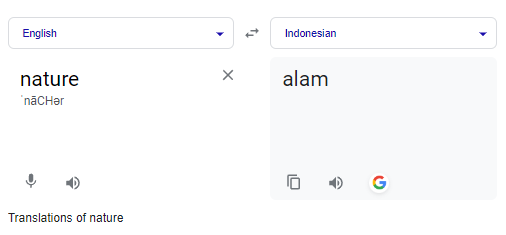

In [15]:
df_locations[df_locations['Description'].str.contains(' alam ')]['City'].value_counts()

City
Yogyakarta    25
Bandung       23
Semarang       7
Jakarta        5
Surabaya       0
Name: count, dtype: int64

### What spots are most loved by tourists?

In [16]:
df_location_ratings = pd.merge(df_locations, df_ratings, left_on='Place_Id', right_on='Place_Id', how='left')
most_loved_places = df_location_ratings.groupby('Place_Name')['Place_Ratings'].sum().reset_index()
most_loved_places.sort_values('Place_Ratings', ascending=False)

Place_Name  Place_Ratings
86   Gereja Perawan Maria Tak Berdosa Surabaya            125
158                           Keraton Surabaya            123
272                        Pantai Parangtritis            123
395                         Taman Sungai Mudal            120
261                             Pantai Kesirat            115
..                                         ...            ...
0                            Air Mancur Menari             36
237                       Museum Ullen Sentalu             34
354                           Taman Barunawati             34
144               Kauman Pakualaman Yogyakarta             33
279                             Pantai Sanglen             31

[437 rows x 2 columns]

### Which category of places are users liking the most?

In [17]:
most_loved_categories = df_location_ratings.groupby('Category', observed=False)['Place_Ratings'].sum().reset_index()
most_loved_categories.sort_values('Place_Ratings', ascending=False)

Category  Place_Ratings
4       Taman Hiburan           9519
1              Budaya           8142
2          Cagar Alam           7440
0              Bahari           3244
5       Tempat Ibadah           1186
3  Pusat Perbelanjaan           1134

### Build a recommender model to suggest other places given a current place name
1. Sets up tables using collaborative filtering algorithm
2. Figures out the place's Place_Id
3. Passes the Place_Id to the tables
4. Converts resulting Place_Ids back to Place_Names
5. Presents results

In [57]:
def find_most_similar_places(place, num=5):
    pivot = df_ratings.pivot_table(index='User_Id', columns='Place_Id', values='Place_Ratings')
    x = pivot.apply(lambda col: col.fillna(col.mean()), axis=0)
    x_corr = x.corr()
    place_id = df_locations[df_locations['Place_Name']==place].iloc[0,0]
    rec_corr = x_corr[place_id]
    rec_corr = rec_corr.sort_values(ascending=False)
    rec_corr.dropna(inplace=True)
    recommendations = []
    for row in pd.DataFrame(rec_corr).iloc[1:num+1,:].iterrows():
        recommendations.append(df_locations[df_locations['Place_Id']==row[0]].iloc[0,1])
    display(recommendations)

# Find the top 10 most similar places (based on ratings)
find_most_similar_places('Monumen Nasional', 10)


['Stone Garden Citatah',
 'Air Mancur Menari',
 'Situ Patenggang',
 'Museum De Javasche Bank',
 'Pantai Nguluran',
 'Goa Pindul',
 'Curug Aseupan',
 'Happyfarm Ciwidey',
 'Umbul Sidomukti',
 'Taman Film']